# Amazon food review dataset apply truncated SVD

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews


# Objective
1. Take 2000 words by TFIDF importance 
2. Calculate cooccurance matrix with neighbourhood of size 5 and count how many times wi occur in context of wj
3. Then do truncated SVD
4. try multiple value of k(find optimal k by amount of variance explained)[use singular value]
5. cluster(kmeans k=50 ) word vector for top 2000
6. word cluster together should be related

# Import data and libraries
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [43]:
#take only 50000 data
print('total data \n',sorted_data['Score'].value_counts())
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(10000)
#take stratified sampling i.e. positive and negative reviews are proportionate to raw data
#testing
_ , clean_data = train_test_split(sorted_data, test_size = 50000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

total data 
 positive    307063
negative     57110
Name: Score, dtype: int64


positive    42159
negative     7841
Name: Score, dtype: int64

In [68]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #testing
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    
clean_data['CleanedText']=final_string
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)
clean_data['CleanedText'].iloc[0]


(50000, 11)


b'plum sweet juici aroma like perfum doesnt hurt good'

# Get top 2000 words by TFIDF score and create co-occurence matrix by window 5

In [69]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
#n=x.shape[0]
#n1=int(n*.3)
#X_test_raw = x[0:n1]
#X_train_raw= x[n1:n+1]
#y_test=y[0:n1]
#y_train=y[n1:n+1]
# Create BOW and try grid search for logistic regreession with penalty l1 and l2
tf_idf_vect = TfidfVectorizer()
final_counts = tf_idf_vect.fit_transform(x)
#use the same vectors to convert test data
#X_test=count_vect.transform(X_test_raw)
indices = np.argsort(tf_idf_vect.idf_)[::-1]
features = tf_idf_vect.get_feature_names()
#testing
top_n = 2000
top_features = [features[i] for i in indices[:top_n]]
print (top_features[0:20])
print('len of top feature',len(top_features))

#remove other words from review
final_string=[]
all_string=[]

i=0
for sent in clean_data['CleanedText'].values:
    i=i+1
    filtered_sentence=[]
    for w in sent.decode('utf8').split():
                #print(w)
                if(w in top_features):
                    filtered_sentence.append(w.encode('utf8'))
                    #if (i==1):
                    #print('print')
                else:
                    continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    if (str1.decode('utf8') !=''):
      final_string.append(str1)
    all_string.append(str1)
    
clean_data['CleanedText']=all_string
#Now final_string is ready to work with
#print(clean_data['CleanedText'].shape)
final_string[0]


['île', 'foetida', 'filo', 'plait', 'filteer', 'filterbag', 'filtr', 'plactic', 'finagl', 'placei', 'finali', 'financ', 'findabl', 'pkt', 'findaspr', 'finefar', 'pkging', 'finess', 'fing', 'fingerfood']
len of top feature 2000


b'disform'

In [80]:
#Convert to cooccurance mat
#type(final_string)
#print(final_string)
window=5
len1=len(top_features)
#print(len)
m=np.zeros([len1,len1])
columns=top_features
rows=top_features
df=pd.DataFrame(m,columns=columns,index=rows)
#print(df)

def cal_occ(sentence,df):
    sen=sentence.split()
    l=len(sen)-1
    for i,word in enumerate(sen):
        for j in range(max(i-window,0),min(i+window+1,l+1)):
            if word!=sen[j]:
                #print('printing',word,sen[j])
                df[word][sen[j]]+=1
                
for sentence in final_string:
    #print('call',sentence)
    cal_occ(sentence.decode('utf8'),df)
    
print(df.shape)    

(2000, 2000)


In [81]:
#top_features
#final_string[0]
print(len)
len(top_features)
#df
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler(with_mean=False).fit(df)
#df = scaler.transform(df)

<built-in function len>


In [90]:
#df

In [74]:
type(U)

numpy.ndarray

# Create countvectorizer using cooccurence matrix

In [85]:
#count_vect = CountVectorizer(vocabulary=top_features) #in scikit-learn
#X = count_vect.fit_transform(final_string)

#print(X.shape)
          
#Cooccurance matrix    
#X = (X.T * X) # this is co-occurrence matrix in sparse csr format
#X.setdiag(0) # sometimes you want to fill same word cooccurence to 0
#print(X.todense()) 

#print(count_vect.vocabulary_)                             
                   
#Create truncated SVD
from sklearn.decomposition import TruncatedSVD

#Try different component
l=[20,50,100,150,200,250]
for i in l:
  svd = TruncatedSVD(n_components=i, n_iter=7, random_state=0)
  svd.fit(df.values)
  #print(svd.explained_variance_ratio_)  
  l1=svd.explained_variance_ratio_
  print('% variance explained with component ',i,svd.explained_variance_ratio_.sum()) 
  #print('singular values',svd.singular_values_)

#So looks like with 25 component 96% variance is explained
#print(svd)

% variance explained with component  20 0.596657737216
% variance explained with component  50 0.716447280124
% variance explained with component  100 0.825836500755
% variance explained with component  150 0.869494648993
% variance explained with component  200 0.913161825629
% variance explained with component  250 0.956826688872


SO by 250 component 96% variance is explained
# Use SVD

In [86]:
#VT = svd.components_
#TruncatedSVD is basically a wrapper around sklearn.utils.extmath.randomized_svd; you can manually call this yourself like this:

from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(df.values, 
                              n_components=250,
                              n_iter=50,
                              random_state=0)

print('U value\n')
#print(U)
print('sigma value\n')
#print(Sigma)
print('VT value\n')
#print(VT)
print(U.shape,Sigma.shape,VT.shape)

U value

sigma value

VT value

(2000, 250) (250,) (250, 2000)


# Form cluster of 10 using those important words SVD value

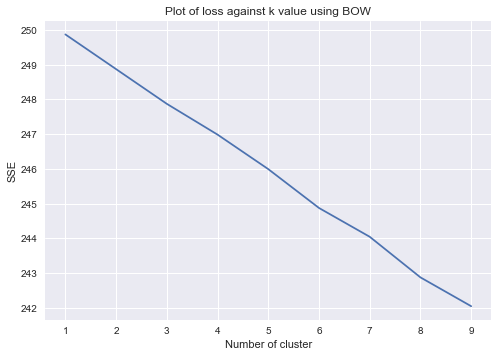

(1,)
in cluster 
 0
[   0    1    2 ..., 1997 1998 1999]
île
foetida
filo
plait
filteer
filterbag
filtr
plactic
finagl
placei
finali
financ
findabl
pkt
findaspr
finefar
pkging
finess
fing
fingerfood
pizzell
finiski
finki
pizzaria
pizzaiola
filmsi
filltrat
plani
figh
plavor
plave
fica
platypus
ficus
fidd
fiddlestick
fieldss
fifficult
figgi
figish
planifolia
fike
plaqueoff
planti
planthard
plantfus
fila
filful
filibert
filippo
fillo
finlandia
pizett
finley
pipa
piroulin
piripiri
firepot
firest
firewood
firmiliar
firsat
piperin
firshand
firsli
pip
pioki
firstit
firtst
fishermen
fishnet
fishstick
fissur
pinhol
fiter
pingshui
pirtl
pistacho
finncrisp
pitr
finnecki
piut
piulp
pitur
finnicki
pittmix
finniki
finnish
pittbul
pitiabl
pith
pite
fiocchetti
firecrack
firefight
pitango
firend
pistol
pistil
pistchio
playabl
fiberi
playdoh
fentimin
podner
podmerch
podg
podd
feng
pocuch
pocono
fennugreek
fenstermach
fentiman
pobabl
podunk
feodorovich
poa
pnw
pnfs
fer
pnb
pnam
ferdi
plzd
poduct
poe
ferm

In [89]:
from sklearn.cluster import KMeans
# Now U is vec presentation of words
n_clusters=10
kmeans=KMeans(n_clusters=10, random_state=0).fit(U)
kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(U)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using BOW")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#a=np.where(kmeans.labels_ == 1)[0]
#b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1

kmeans = KMeans(init='k-means++',n_clusters=50, max_iter=100).fit(U)
n_clusters=50
print(a.shape)
for i in range(n_clusters):
  a=np.where(kmeans.labels_ == i)[0]
  print('in cluster \n',i)
  print(a[0:]) 
  for j in a:
    print(top_features[j])  


# Observation
Most of the cluster contains 1-2 words and most of the words in one cluster

Ignore the above 2 plots those plots are plotted below again